# Toy example

**Goal:** Get a basic (toy) example setup that will be easy to adapt for Sara's inputs


**Table of Contents**

1. Toy data setup
2. (Basic) [slot attention](https://arxiv.org/abs/2006.15055) architecture
3. Using xformers [TSPN](https://arxiv.org/abs/2006.16841) instead of GRU, as done in the [global PFlow](htts://arxiv.org/pdf/2212.01328.pdf) work


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import datetime
import time

import collections
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import logging

# The slot attn code
import os
os.sys.path.append('../google-research')

import slot_attention.data as data_utils
import slot_attention.model as model_utils
import slot_attention.utils as utils

from slot_attention.set_prediction.train import train_step

%load_ext autoreload
%autoreload 2

## 1. Toy data setup

Let's start trying to predict the positions of Gaussian blobs!

In [ ]:
nTrain = 10000
nTest = 1000

nPhotons = 2
nFeatures = 3 # (x,y) and the E

C = np.random.uniform(-2,2,size=(nTrain,nPhotons,1,nFeatures-1))

`C`:
- C[i,0] is the (x,y) location of the first "photon" in event i 
- C[i,1] is the (x,y) location of the second "photon" in event i

Photon energies, consider uniformly distributed fomr 5 -- 500 GeV.

In [ ]:
E = np.random.uniform(5,500,size=(nTrain, nPhotons,1))

In [ ]:
plt.hist(E[:,0],color='royalblue',alpha=0.4,label='$\gamma$ 1')
plt.hist(E[:,1],color='hotpink',alpha=0.4,label='$\gamma$ 2')

plt.xlabel('Photon energy [GeV]',fontsize=20,loc='right')
plt.ylabel('Entries',fontsize=20,loc='top')
plt.legend(fontsize=16)
plt.show()

In [402]:
# Let's predict the log energy
Y = np.concatenate([C.squeeze(), np.log(E)],axis=-1)
Y.shape

(10000, 2, 3)

In [403]:
E.shape

(10000, 2, 1)

For the regression targets, concat the coords and E

In [404]:
Y = np.concatenate([C.squeeze(),E],axis=-1)
Y.shape

(10000, 2, 3)

Very simple model, lets assume there's 1 photon / GeV of energy.

In [405]:
nSamples = np.floor(E.squeeze()).astype(int)
nSamples

array([[ 89, 113],
       [157, 304],
       [331, 300],
       ...,
       [469, 394],
       [ 47, 214],
       [437, 456]])

In [409]:
X_cat = [] 

X1 = [] 
X2 = [] 

for i, (E1, E2) in enumerate(E.squeeze()):
    
    nSamples1=int(E1)
    nSamples2=int(E2)

    x1_i = C[i,0] + np.random.randn(nSamples1, nFeatures-1)
    x2_i = C[i,1] + np.random.randn(nSamples2, nFeatures-1)
    
    X1.append(x1_i)
    X2.append(x2_i)

    X_cat.append( np.concatenate([x1_i, x2_i], axis=0) )
    
print(X_cat_list[0].shape)

(1, 447, 2)


In [410]:
# the first (x,y) pred prob I tried
# nSamples=10
# X = C + np.random.randn(nTrain, nPhotons,  nSamples, nFeatures-1)
# X_cat = np.reshape(X, (nTrain, nPhotons * nSamples, nFeatures ) )

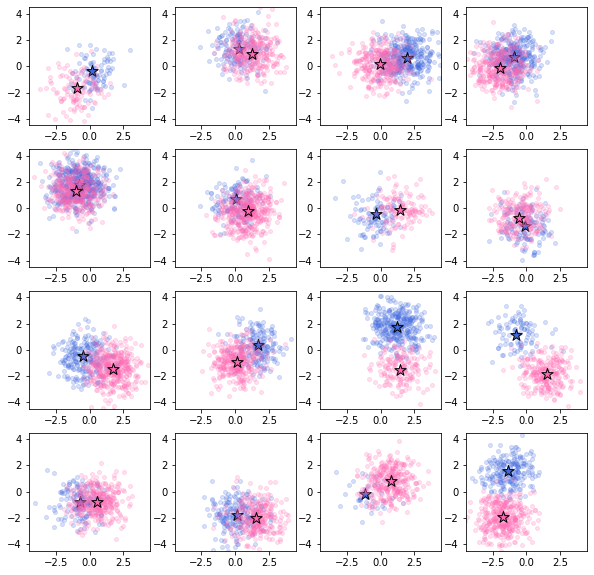

In [411]:
fig, ax = plt.subplots(4,4, figsize=(10,10))

for k in range(16):
    
    i = k // 4
    j = k % 4
    
    axi = ax[i,j]
    
    for i,color_i,Xi in zip([0,1],['royalblue','hotpink'],[X1,X2]):
        
        axi.scatter(*Xi[k].T,16,color=color_i,alpha=0.2)
        axi.scatter(*C[k,i,:2].T, 144, marker="*",color=color_i, edgecolor='k')
    
    axi.set_xlim(-4.5,4.5)
    axi.set_ylim(-4.5,4.5)
    
plt.show()   

OK, cool beans, this looks like a cute toy problem :) 

**Follow-ups:** 
- Add discretization (to a 9x9 grid)
- Make the energy a function of the blob radius, so we can _predict_ the energy (already included in the model above now)

In [412]:
# (nTrain, nPhotons, nSamples, nFeatures )
X.shape

(1000, 2, 10, 2)

In [413]:
# Which E deposits came from which photon is unknown, so concatenate them together
# X_cat = np.reshape(X, (nTrain, nPhotons * nSamples, nFeatures ) )

# X_cat.shape

In [414]:
# for paper results -- using (128, 128) img
resolution = (9,9) # for Sara's example, want a (9,9) 

In [415]:
X_bin = np.concatenate([
    np.histogram2d(*Xi.T, resolution, [(-4.5,4.5),(-4.5,4.5)])[0].reshape(1,*resolution,1) 
    for Xi in X_cat], axis=0 )

# Let's pass the log(E) as input instead of E
non_zero = X_bin > 0
X_bin[non_zero] = np.log(X_bin[non_zero])

X_bin.shape

(10000, 9, 9, 1)

In [416]:
C.shape

(10000, 2, 1, 2)

Let's make another event display of what the ML inputs look like!

(Discretized showers and not having a color coding for the shower deposits.)

In [417]:
ex = np.linspace(-4.5,4.5,resolution[0]+1)
xx=0.5 * (ex[1:] + ex[:-1])

Xi,Yi = np.meshgrid(xx,xx)
Xi = Xi.flatten()
Yi = Yi.flatten()

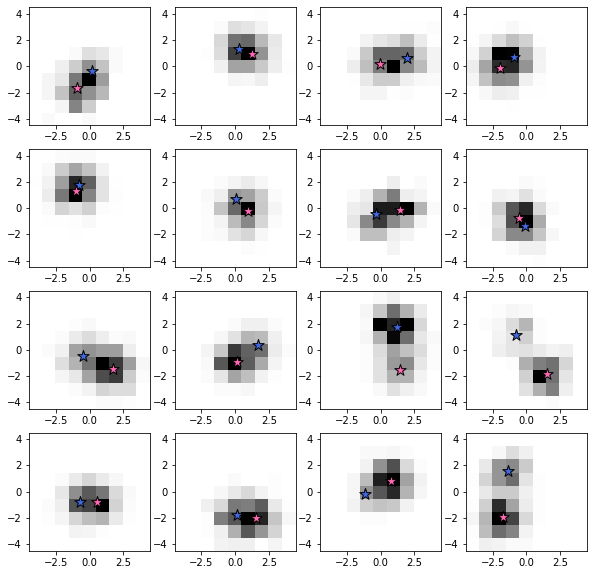

In [418]:
fig, ax = plt.subplots(4,4, figsize=(10,10))

for k in range(16):
    
    i = k // 4
    j = k % 4
    
    axi = ax[i,j]
    
    # Draw the shower
    axi.hist2d(Xi,Yi, resolution, [(-4.5,4.5),(-4.5,4.5)], weights=np.exp(X_bin[k].T.flatten()),cmap='Greys')
    
    # Draw the truth labels on the plot
    for i,color_i in enumerate(['royalblue','hotpink']):
        axi.scatter(*C[k,i].T, 144, marker="*",color=color_i, edgecolor='k')
        
plt.show()   

In [419]:
'''
Test data
'''

# targets
C_test = np.random.uniform(-2,2,size=(nTest,nPhotons,1,nFeatures-1))
E_test = np.random.uniform(5,500,size=(nTest, nPhotons,1))

Y_te = np.concatenate([C_test.squeeze(),E_test],axis=-1)
print('Y_te',Y_te.shape)

# images
X_cat_test = []
for i, (E1, E2) in enumerate(E_test.squeeze()):
    
    x1_i = C[i,0] + np.random.randn(int(E1), nFeatures-1)
    x2_i = C[i,1] + np.random.randn(int(E2), nFeatures-1)
    
    X_cat_test.append( np.concatenate([x1_i, x2_i], axis=0) )

X_bin_te = np.concatenate([ 
        np.histogram2d(*Xi.T, resolution, [(-4.5,4.5),(-4.5,4.5)])[0].reshape(1,*resolution,1) 
        for Xi in X_cat_test
    ], axis=0 )

X_bin_te[X_bin_te > 0] = np.log(X_bin_te[X_bin_te > 0])

X_bin_te.shape

Y_te (1000, 2, 3)


(1000, 9, 9, 1)

## 2. Slot attention (from paper)

Recommendation from Lukas: Don't try to start from scratch... just use the existing implementation :)

Below is just copying some code from `train.py`

In [420]:
# Set up some of the parameters from the flags
model_dir = '/tmp/set_prediction/'

batch_size = 512 
num_slots = 2 # for detecting 2 photons
num_iterations = 3 # 3 steps of slot attention
base_learning_rate = 0.0004
num_train_steps = 1000 # altho longer, 150000 from paper code
warmup_steps = 200
decay_rate = 0.5
decay_steps = 50000

tf.random.set_seed(0)

In [421]:
optimizer = tf.keras.optimizers.Adam(base_learning_rate, epsilon=1e-08)

In [422]:
model = model_utils.build_model(resolution, 
                                batch_size, 
                                num_slots=nPhotons,
                                num_iterations=num_iterations, 
                                num_channels=1,
                                model_type="sara_model")

In [423]:
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(512, 9, 9, 1)]          0         
_________________________________________________________________
slot_attention_sara_21 (Slot (512, 2, 3)               78435     
Total params: 78,435
Trainable params: 78,435
Non-trainable params: 0
_________________________________________________________________


In [424]:
# Prepare checkpoint manager.
global_step = tf.Variable(
  0, trainable=False, name="global_step", dtype=tf.int64)

ckpt = tf.train.Checkpoint(
  network=model, optimizer=optimizer, global_step=global_step)

ckpt_manager = tf.train.CheckpointManager(
  checkpoint=ckpt, directory=model_dir, max_to_keep=5)

ckpt.restore(ckpt_manager.latest_checkpoint)

if ckpt_manager.latest_checkpoint:
    logging.info("Restored from %s", ckpt_manager.latest_checkpoint)
else:
    logging.info("Initializing from scratch.")

In [425]:
X_bin.shape

(10000, 9, 9, 1)

In [426]:
C.squeeze().shape

(10000, 2, 2)

In [427]:
X_test = tf.convert_to_tensor(X_bin_te, dtype=tf.float32) # nTrain, 9, 9
Y_test = tf.convert_to_tensor(Y_te, dtype=tf.float32) # nTrain, 2, 2

print(X_test.shape,Y_test.shape)

(1000, 9, 9, 1) (1000, 2, 3)


In [ ]:
start = time.time()

Loss_train = []
Loss_test   = []

for i in range(num_train_steps):
       
    # Get a sample
    ix  = np.random.choice(np.arange(nTrain),size=batch_size, replace=False)
    batch = {"image": tf.convert_to_tensor(X_bin[ix], dtype=tf.float32), # batch_size, 9, 9
             "target": tf.convert_to_tensor(Y[ix], dtype=tf.float32) # batch_size, 2, 2
            }

        
    # Learning rate warm-up.
    if global_step < warmup_steps:
        learning_rate = base_learning_rate * tf.cast(
          global_step, tf.float32) / tf.cast(warmup_steps, tf.float32)
    else:
        learning_rate = base_learning_rate
        learning_rate = learning_rate * (decay_rate ** (
        tf.cast(global_step, tf.float32) / tf.cast(decay_steps, tf.float32)))
    optimizer.lr = learning_rate.numpy()

    loss_value = train_step(batch, model, optimizer)

    # Update the global step. We update it before logging the loss and saving
    # the model so that the last checkpoint is saved at the last iteration.
    global_step.assign_add(1)

    Loss_train.append(loss_value.numpy())
    
    '''
    And now for the test loss
    '''
    preds = model(X_test, training=False)
    loss_value = utils.hungarian_huber_loss(preds, Y_test)
    Loss_test.append(loss_value.numpy())
    
    print('i=',i,', train loss = ',Loss_train[-1],', test loss = ',Loss_test[-1])
        

i= 0 , train loss =  173.12808 , test loss =  168.10582
i= 1 , train loss =  169.14902 , test loss =  168.12537
i= 2 , train loss =  166.13074 , test loss =  168.13737
i= 3 , train loss =  169.9133 , test loss =  168.10994
i= 4 , train loss =  168.35568 , test loss =  168.08325
i= 5 , train loss =  173.21938 , test loss =  168.06213
i= 6 , train loss =  169.48997 , test loss =  168.04207
i= 7 , train loss =  169.3476 , test loss =  168.01466
i= 8 , train loss =  172.04887 , test loss =  168.00357
i= 9 , train loss =  169.12233 , test loss =  167.9384
i= 10 , train loss =  165.05772 , test loss =  167.93031
i= 11 , train loss =  171.95473 , test loss =  167.88612
i= 12 , train loss =  165.27472 , test loss =  167.84348
i= 13 , train loss =  168.9347 , test loss =  167.80295
i= 14 , train loss =  170.82884 , test loss =  167.74364
i= 15 , train loss =  164.14717 , test loss =  167.7087
i= 16 , train loss =  170.07033 , test loss =  167.61453
i= 17 , train loss =  171.7746 , test loss =  

In [ ]:
plt.plot(Loss_train,label='train')
plt.plot(Loss_test,label='test')
plt.xlabel('Iterations',fontsize=20,loc='right')
plt.ylabel('Loss',fontsize=20,loc='top')

Based on this loss curve, I would 
1) Use a larger batch size
2) During the plateau I would start decreasing the learning rate :) 

**Will be important to evaluate whether the loss is lower or higher than the CNN / MLP models when using the same loss!!**

### Another check: Make some event dispalys

In [ ]:
preds = model(batch_test["image"], training=False).numpy()

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(10,10))

for k in range(16):
    
    i = k // 4
    j = k % 4
    
    axi = ax[i,j]
    
    # Draw the shower
    axi.hist2d(Xi,Yi, resolution, [(-4,4),(-4,4)], weights=X_bin[k].T.flatten(),cmap='Greys')
    
    
    for i,color_i in enumerate(['royalblue','hotpink']):
    
        # Draw the truth labels on the plot
        axi.scatter(*C[k,i].T, 225, marker="*",color=color_i, edgecolor='k')
        
        # Draw on the model predictions
        axi.scatter(*preds[k,i].T, 144, marker="s",color='mediumpurple', edgecolor='k')
    
        
plt.show()   

## Proposals for next steps

1. Use the CNN that worked best for photon construction (i.e, insert the CNN architecture here)
2. Scan over the hyperparameters